In [1]:
!pip install gym==0.23.1 --quiet
!pip install tensorflow --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 22.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
#Library for environments
import gym
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import generate_random_map

#Librairies to represent the output
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

#Essential libraries for computation
import numpy as np
import random
import tensorflow as tf
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map)
env.reset()
plt.imshow(env.render('rgb-array'))

In [3]:
# Get GPU device name
if tf.test.gpu_device_name():
    print('\nDefault GPU Device:', tf.test.gpu_device_name())
else:
    print('\nNo GPU device found')


Default GPU Device: /device:GPU:0


In [13]:
class DQNAgent:
    """
    The agent uses a neural network to approximate the Q-function and
    epsilon-greedy exploration strategy with decay
    """
    def __init__(self, state_size, action_size):
        # Set device before other initializations
        self.device_name = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device_name}")

        # Environment parameters
        self.state_size = state_size
        self.action_size = action_size

        # Learning parameters
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.1  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.learning_rate = 0.001  # Learning rate for the optimizer

        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.hidden_size = 256

        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()  # Initialize target model to be same as model

        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def _build_model(self):
        """
        Neural Network to approximate Q-value function:
        * Input: state
        * Output: Q-values for each action
        """
        model = nn.Sequential(
            nn.Linear(self.state_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.action_size)
        ).to(self.device_name)
        
        return model

    def update_target_model(self):
        """Update the target model with the weights of the model"""
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0).to(self.device_name)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values[0]).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample random experiences from memory
        minibatch = random.sample(self.memory, self.batch_size)

        states = torch.FloatTensor(np.array([x[0] for x in minibatch])).to(self.device_name)
        next_states = torch.FloatTensor(np.array([x[3] for x in minibatch])).to(self.device_name)
        actions = torch.LongTensor(np.array([x[1] for x in minibatch])).to(self.device_name)
        rewards = torch.FloatTensor(np.array([x[2] for x in minibatch])).to(self.device_name)
        dones = torch.BoolTensor(np.array([x[4] for x in minibatch])).to(self.device_name)

        # Predict Q-values for current and next states
        current_q_values = self.model(states)
        next_q_values = self.target_model(next_states)

        # Create training targets
        targets = current_q_values.clone()

        for i in range(self.batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * torch.max(next_q_values[i])

        loss = nn.MSELoss()(current_q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def convert_state(self, state):
        """Convert state number to one-hot encoding"""
        state_one_hot = np.zeros(self.state_size)
        state_one_hot[state] = 1
        return state_one_hot

def train_dqn_agent(env, agent, episodes=1000):
    """
    Train the DQN agent on the environment
    """
    scores = []
    for episode in range(episodes):
        state, _ = env.reset()
        state = agent.convert_state(state)
        score = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)

            next_state = agent.convert_state(next_state)
            agent.remember(state, action, reward, next_state, done)

            # Move to next state
            state = next_state
            score += reward

            agent.replay()

        scores.append(score)

        if (episode + 1) % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode: {episode + 1}, Average Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.2f}")

    return scores

def create_agent(env):
    """
    Create and initialize a DQN agent for the given environment
    """
    state_size = env.observation_space.n  # Number of states
    action_size = env.action_space.n      # Number of actions
    agent = DQNAgent(state_size, action_size)
    model = agent.model
    return agent, model

In [15]:
# Initialize the environment and agent
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map)
agent, model = create_agent(env)

# Training parameters
n_episodes = 10000
max_steps = 100  # Maximum steps per episode
training_history = {
    'scores': [],
    'avg_scores': [],
    'epsilons': [],
    'steps': []
}

Using device: cuda


In [16]:
# Training loop
for episode in range(n_episodes):
    state = env.reset()  # Just get the state
    state = agent.convert_state(state)
    score = 0
    done = False
    steps = 0

    for step in range(max_steps):
        # Choose and take action
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)  # Updated step unpacking

        # Convert next_state and store experience
        next_state = agent.convert_state(next_state)
        agent.remember(state, action, reward, next_state, done)

        # Move to next state
        state = next_state
        score += reward
        steps += 1

        # Train the network
        agent.replay()

        if done:
            break

    # Store training history
    training_history['scores'].append(score)
    training_history['epsilons'].append(agent.epsilon)
    training_history['steps'].append(steps)

    # Calculate average score over last 100 episodes
    avg_score = np.mean(training_history['scores'][-100:])
    training_history['avg_scores'].append(avg_score)

    # Print progress
    if (episode + 1) % 100 == 0:
        print(f"Episode: {episode + 1}/{n_episodes}")
        print(f"Score: {score:.2f}")
        print(f"Average Score (last 100): {avg_score:.2f}")
        print(f"Epsilon: {agent.epsilon:.3f}")
        print(f"Steps: {steps}")
        print("-" * 40)
        # Optional: render the environment to see the agent's behavior
        if episode % 100 == 0:
            env.render()

# Print final training results
print("\nTraining completed!")
print(f"Final average score: {training_history['avg_scores'][-1]:.2f}")
print(f"Final epsilon: {agent.epsilon:.3f}")

Episode: 100/10000
Score: 0.00
Average Score (last 100): 0.00
Epsilon: 0.100
Steps: 3
----------------------------------------
Episode: 200/10000
Score: 0.00
Average Score (last 100): 0.00
Epsilon: 0.100
Steps: 6
----------------------------------------
Episode: 300/10000
Score: 0.00
Average Score (last 100): 0.00
Epsilon: 0.100
Steps: 5
----------------------------------------
Episode: 400/10000
Score: 0.00
Average Score (last 100): 0.00
Epsilon: 0.100
Steps: 36
----------------------------------------
Episode: 500/10000
Score: 0.00
Average Score (last 100): 0.00
Epsilon: 0.100
Steps: 2
----------------------------------------
Episode: 600/10000
Score: 0.00
Average Score (last 100): 0.00
Epsilon: 0.100
Steps: 100
----------------------------------------
Episode: 700/10000
Score: 0.00
Average Score (last 100): 0.00
Epsilon: 0.100
Steps: 55
----------------------------------------
Episode: 800/10000
Score: 0.00
Average Score (last 100): 0.00
Epsilon: 0.100
Steps: 2
---------------------

In [18]:
def plot_epsilon(epsilon):
    steps = np.arange(0, len(epsilon), 1)
    plt.clf()
    # plt.gcf().set_size_inches((7, 7))
    plt.plot(steps, epsilon, marker="o", markersize=1)
    plt.ylabel("Epsilon ")
    plt.xlabel("Step")
    plt.tight_layout()
    plt.show()

def plot_rewards(rewards, episodes, mult = 100):
    average_rewards = np.split(np.array(rewards), episodes/mult)
    steps = mult * np.arange(len(average_rewards))
    plt.clf()
    plt.plot(steps, np.average(average_rewards, 1))
    plt.ylabel("Average Reward")
    plt.xlabel("Episode")
    plt.tight_layout()
    plt.show()

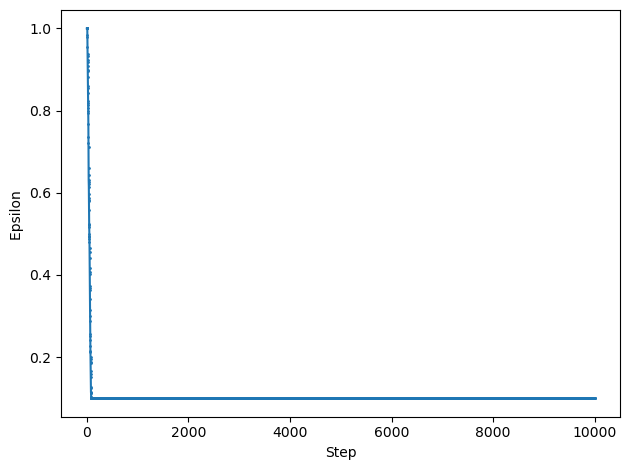

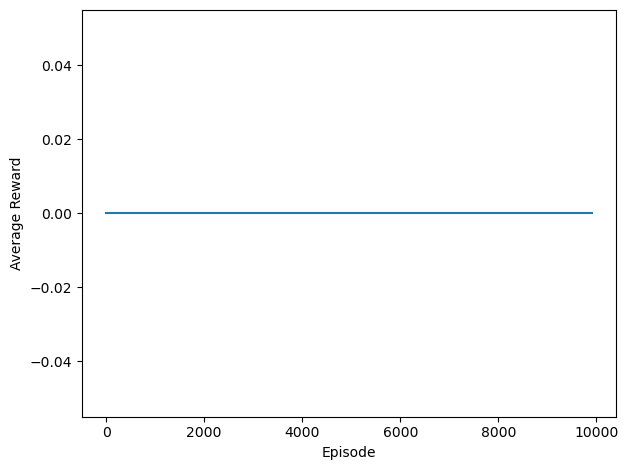

In [20]:
plot_epsilon(training_history['epsilons'])
plot_rewards(training_history['scores'], n_episodes)

In [ ]:
# Save Model
torch.save(model, 'agent.pth')

# Load Model
model.load_state_dict(torch.load('agent.pth', weights_only=True))